----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]             300
           Sigmoid-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
           Sigmoid-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
           Sigmoid-6               [-1, 1, 100]               0
            Linear-7               [-1, 1, 100]          10,100
           Sigmoid-8               [-1, 1, 100]               0
            Linear-9               [-1, 1, 100]          10,100
          Sigmoid-10               [-1, 1, 100]               0
           Linear-11               [-1, 1, 100]          10,100
          Sigmoid-12               [-1, 1, 100]               0
           Linear-13               [-1, 1, 100]          10,100
          Sigmoid-14               [-1,

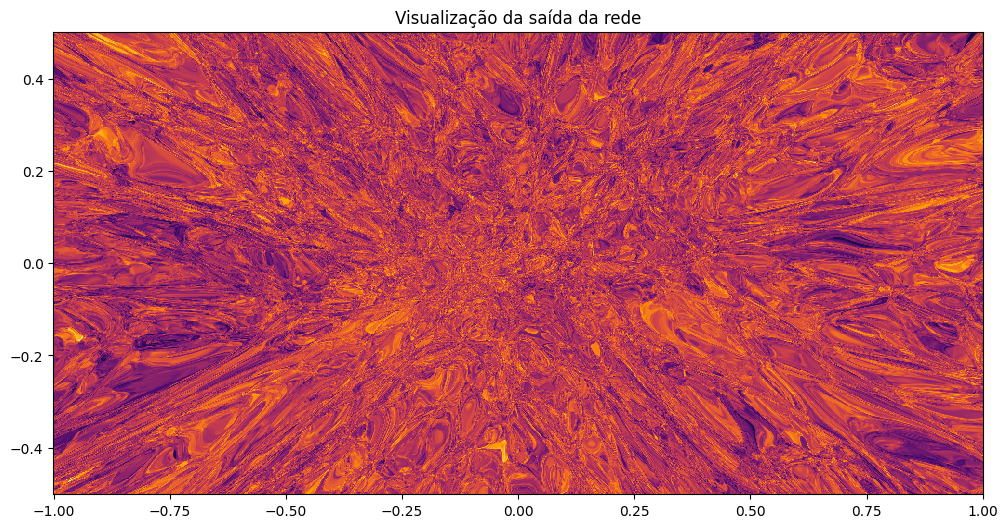

In [7]:
import torch
from torchsummary import summary  # Para resumo da arquitetura da rede

# Função auxiliar para inicialização de pesos
def initWeights(m):
    """Inicializa os pesos da rede neural com distribuição uniforme."""
    # Aplica inicialização apenas para camadas lineares e convolucionais
    if (type(m) == torch.nn.Linear or
        type(m) == torch.nn.Conv2d or
        type(m) == torch.nn.Conv3d):
        torch.nn.init.uniform_(m.weight, a=-10, b=10)  # Pesos entre -10 e 10
        torch.nn.init.uniform_(m.bias, a=-1, b=1)      # Vieses entre -1 e 1

# Definição da classe da rede neural
class NN(torch.nn.Module):
    def __init__(self, inputDimension, hiddenDimensions, outputDimension,
                 activationFunction=torch.nn.Tanh()):
        super().__init__()

        # Construção sequencial das camadas
        modules = []

        # Primeira camada (entrada para primeira oculta)
        modules.append(torch.nn.Linear(inputDimension, hiddenDimensions[0]))
        modules.append(activationFunction)

        # Camadas ocultas intermediárias
        for i in range(len(hiddenDimensions) - 1):
            modules.append(torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i+1]))
            modules.append(activationFunction)

        # Camada de saída
        modules.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))

        # Modelo sequencial
        self.model = torch.nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)

# Configuração e criação do modelo
torch.manual_seed(5)  # Para reprodutibilidade

# Parâmetros da arquitetura
numberOfHiddenNeurons = 100  # Neurônios por camada oculta
numberOfLayers = 10          # Número de camadas ocultas
hiddenDimensions = [numberOfHiddenNeurons] * numberOfLayers
activationFunction = torch.nn.Sigmoid()  # Função de ativação

# Criação do modelo
model = NN(2, hiddenDimensions, 1, activationFunction)
model.apply(initWeights)  # Aplica a inicialização de pesos

# Exibe resumo da arquitetura (dimensão de entrada: (1,2))
summary(model, (1, 2))

# Criação da grade para visualização
Nx = 1000  # Pontos no eixo x
Ny = 500   # Pontos no eixo y

# Gera coordenadas da grade
x = torch.linspace(-1, 1, Nx)
y = torch.linspace(-0.5, 0.5, Ny)
x, y = torch.meshgrid(x, y, indexing="ij")

# Prepara entrada para a rede (concatena coordenadas)
input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)

# Calcula saída da rede (sem calcular gradientes)
with torch.no_grad():
    output = model(input).detach().reshape((Nx, Ny))

# Configuração do tipo de visualização
INTERACTIVE_PLOT = False  # Alternar para True para plot interativo

# Visualização não interativa
if not INTERACTIVE_PLOT:
    import matplotlib.pyplot as plt

    # Cria figura e plota a saída
    fig, ax = plt.subplots(figsize=(12, 6))
    cp = ax.pcolormesh(x, y, output, cmap=plt.cm.inferno, shading='auto')
    plt.title('Visualização da saída da rede')
    plt.show()

# Visualização interativa (permite zoom)
else:
    import matplotlib
    matplotlib.use('qtagg')  # Configura backend para interatividade
    import matplotlib.pyplot as plt

    class ZoomPlot:
        """Classe para plot interativo com zoom."""

        def __init__(self):
            # Configurações iniciais
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(111)

            # Limites iniciais do plot
            self.xmin, self.xmax = -2., 2.
            self.ymin, self.ymax = -2., 2.

            # Variáveis para controle do zoom
            self.xpress = self.xmin
            self.xrelease = self.xmax
            self.ypress = self.ymin
            self.yrelease = self.ymax

            # Parâmetros de renderização
            self.resolution = 400  # Resolução da grade
            self.maxiters = 30     # Máximo de iterações

            # Conecta eventos do mouse
            self.fig.canvas.mpl_connect('button_press_event', self.onpress)
            self.fig.canvas.mpl_connect('button_release_event', self.onrelease)

            # Plota a visualização inicial
            self.plot_fixed_resolution(self.xmin, self.xmax, self.ymin, self.ymax)

        def plot_fixed_resolution(self, x1, x2, y1, y2):
            """Renderiza a saída da rede na região especificada."""
            # Cria grade
            x = torch.linspace(x1, x2, self.resolution)
            y = torch.linspace(y1, y2, self.resolution)
            x, y = torch.meshgrid(x, y, indexing="ij")

            # Prepara entrada
            input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)

            # Calcula saída
            with torch.no_grad():
                output = model(input).detach().reshape((self.resolution, self.resolution))

            # Atualiza plot
            self.ax.clear()
            self.ax.set_xlim(x1, x2)
            self.ax.set_ylim(y1, y2)
            self.ax.pcolormesh(x, y, output, cmap=plt.cm.inferno, shading='auto')
            plt.title('Plot interativo - clique e arraste para zoom')
            plt.show()
            self.fig.canvas.draw()

        def onpress(self, event):
            """Registra ponto inicial do zoom."""
            if event.button != 1: return
            self.xpress = event.xdata
            self.ypress = event.ydata

        def onrelease(self, event):
            """Aplica zoom na região selecionada."""
            if event.button != 1: return
            self.xrelease = event.xdata
            self.yrelease = event.ydata

            # Determina nova região
            self.xmin = min(self.xpress, self.xrelease)
            self.xmax = max(self.xpress, self.xrelease)
            self.ymin = min(self.ypress, self.yrelease)
            self.ymax = max(self.ypress, self.yrelease)

            # Replota
            self.plot_fixed_resolution(self.xmin, self.xmax, self.ymin, self.ymax)

    # Cria e exibe o plot interativo
    plot = ZoomPlot()